# What is funny 

This notebook discuss about :
- how funny is defined in this project : 
    - definition : Funny for most of the person that have seen it (remove pictures with no significance number of votes) (30min)
    - metric used to assess it (30min)
    - presentation of the funniest and worst caption, how they were found (1-2h)
- what type of caption are found funnier :
    - Are funny captions shorter? (df["caption"].str.len()) (1h)
    - More “?” or “!” in funny captions? (regex count) (1h)
    - do lexical diversity have fun effect : unexpected word (nltk, textstat) (2h)
    - Are funny captions more positive or negative? (2h)
    - Funnier captions are less semantically aligned with the image (more surprising) (CLIP (or BLIP) ou regarder ce que cyrielle elle a fait) (3h)
- what features most strongly predict humor? (random forest) - Features: sentiment, length, word embeddings, punctuation (4h)
- Funniest themes - word cloud (2h)

What is shown here is that : 
 % write results HERE (2-3h)
- most votes are to say it's unfunny, funny assesmsnt reprensent .. % of the votes --> it's quite rare to be perceived as funny
- distribution of mean : squared
- Average caption length, variance, number of words.

Visualiton to use : 
- distribution of humor score
- boxplots
- word cloud
- Scatterplot of image-caption similarity vs. funniness


idée pour politic : check if left and right are used

### Plannification of the work
estimated time ~20h 
finish result in next 4 weeks to have time to write result nicely -> 5h per week


## Data preparation

In [49]:
from scipy.stats import chisquare
from scipy.stats import zscore

In [5]:
import pandas as pd
import numpy as n
import pickle
import re
from pathlib import Path
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

"""
root = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
while root.parent != root:
    if ((root / ".git").exists() and 
        (root / "README.txt").exists() and 
        (root / "results.ipynb").exists()): break
    root = root.parent
if str(root) not in sys.path: sys.path.insert(0, str(root))

print("Root folder at: ", root)"""

# Detect root starting from this file or from notebook’s cwd
try:
    start_path = Path(__file__).resolve()
except NameError:
    start_path = Path.cwd()

root = start_path
while root != root.parent:
    # Check for any known project markers
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Sanity check — fallback if nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("⚠️ Project root not found — defaulting to current working directory")
    root = Path.cwd()

print(f"✅ Root folder detected at: {root}")

# Add project root to sys.path if not already
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

from src.utils.paths import *
from src.utils.general_utils import *

stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH
with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)


✅ Root folder detected at: /Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42


In [107]:
dataA = data['dataA']
# dataC est un DataFrame de métadonnées de tous les cartoon contests.
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']


In [108]:
# MERGE dfs
# Ajouter une colonne "source_df" avant de concaténer
for i, df in enumerate(dataA):
    df['source_df'] = i  # i correspond à la position dans la liste dataA
dataTEST_merged = pd.concat(dataA, ignore_index=True)
#dataA_merged = pd.concat(dataA, ignore_index=True)


In [94]:
dataA_merged['combined_score'] = dataA_merged['funny_z'] - dataA_merged['not_funny_z']
dataA_merged['rank_funny'] = dataA_merged['combined_score'].rank(ascending=False)


In [106]:
# Allow to see the problem with the mean metric !! 
" Here 'lunch is on me' is not the funniest will it has A LOT (15232) of persons that voted for it as funny, and is after one that has 1175 votes as funny"
Max_mean = dataA_merged[dataA_merged['mean'] > 2.5].sort_values('mean', ascending=False)
display(Max_mean)

Max_rank = dataA_merged[dataA_merged['rank_funny'] < 5].sort_values('rank_funny')
display(Max_rank)


,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_over_total,unfunny_over_total,source_df,not_funny_z,funny_percentile,funny_z,combined_score,rank_funny
452628,Mission accomplished. We will report that this...,2.998918,0.001083,924,0,1,923,0.998918,0.000000,88,-6.900273,1.000000,31.699261,38.599534,1.0
983727,3 ..2.. 1..,2.671296,0.034164,432,61,20,351,0.812500,0.141204,178,-5.254825,0.999998,22.689513,27.944338,4.0
213623,I'll never let go.,2.634196,0.019615,1468,244,49,1175,0.800409,0.166213,43,-4.573645,0.999999,27.000894,31.574538,3.0
862178,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,0.604444,0.086627,153,-5.215048,1.000000,28.378513,33.593560,2.0


,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_over_total,unfunny_over_total,source_df,not_funny_z,funny_percentile,funny_z,combined_score,rank_funny
452628,Mission accomplished. We will report that this...,2.998918,0.001083,924,0,1,923,0.998918,0.000000,88,-6.900273,1.000000,31.699261,38.599534,1.0
862178,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,0.604444,0.086627,153,-5.215048,1.000000,28.378513,33.593560,2.0
213623,I'll never let go.,2.634196,0.019615,1468,244,49,1175,0.800409,0.166213,43,-4.573645,0.999999,27.000894,31.574538,3.0
983727,3 ..2.. 1..,2.671296,0.034164,432,61,20,351,0.812500,0.141204,178,-5.254825,0.999998,22.689513,27.944338,4.0


## Definition of funny 

In this project, we decided to use ratio of funny and unffunny over total number of votes in order to remove the effect of the large number of not funny votes. In addition, this ratio is also multiplied by the log of number of votes in order to give more weight to captions with many votes. 
Then this two metric are combined and used to creat a ranking of the all caption

### funny metrics 

There is a LOT more unfunny votes than funny votes, therefor the distribution is skewed and the mean is biased, 
to counter this we chose different metric than the mean to assess the funny score.
Funny caption are assessed throught the ratio funny/total
not funny caption are



Total votes: not_funny         210747483
somewhat_funny     57140251
funny              23212253
dtype: int64


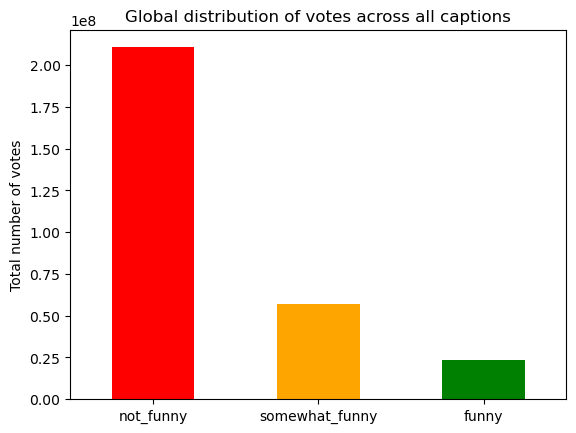

Chi2 = 205825338.15826908 p-value = 0.0


In [11]:
# plot distribution votes pour une caption : skewed ? faire test statistique? 
from scipy.stats import shapiro

vote_cols = ['not_funny', 'somewhat_funny', 'funny']

# Somme cumulée de toutes les captions
total_votes = dataA_merged[vote_cols].sum()

print("Total votes:", total_votes)

# Barplot global
total_votes.plot(kind='bar', color=['red','orange','green'])
plt.ylabel("Total number of votes")
plt.xticks(rotation=0)
plt.title("Global distribution of votes across all captions")
plt.show()

# Test Chi-square vs distribution uniforme
observed = total_votes.values
expected = [observed.sum()/3]*3
chi2_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
print("Chi2 =", chi2_stat, "p-value =", p_val)



In [82]:
dataA_merged['funny_over_total']= dataA_merged['funny']/dataA_merged['votes']
dataA_merged['unfunny_over_total']= dataA_merged['not_funny']/dataA_merged['votes']
dataA_merged['not_funny_z'] = zscore(dataA_merged['unfunny_over_total'] * n.log1p(dataA_merged['votes']))
dataA_merged['funny_z'] = zscore(dataA_merged['funny_over_total'] * n.log1p(dataA_merged['votes']))

In [68]:
dataA_merged

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_over_total,unfunny_over_total,source_df,not_funny_z
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,0.260870,0.347826,0,-4.063701
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,0.263158,0.421053,0,-4.479044
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,0.177778,0.466667,0,-3.470637
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,0.093750,0.468750,0,-3.754175
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,0.176471,0.558824,0,-3.086513
...,...,...,...,...,...,...,...,...,...,...,...
2292673,Looks like we took a wrong turn at the Hubble ...,1.023256,0.016347,86,84,2,0,0.000000,0.976744,383,1.472843
2292674,Post-modern just doesn't do it for me.,1.022222,0.015625,90,88,2,0,0.000000,0.977778,383,1.566072
2292675,How was I supposed to know they covered themse...,1.020833,0.014654,96,94,2,0,0.000000,0.979167,383,1.698110
2292676,"No, they wanted us to teleport the giveaway ca...",1.020619,0.020619,97,96,0,1,0.010309,0.989691,383,1.810010


In [ ]:
def add_funny_ratios(df):
    """
    Adds ratio columns based on 'Funny' and 'Not funny' columns.
    """
    df['funny_over_total'] = n.where(df['votes'] != 0, df['funny'] / df['votes'], n.nan)
    df['unfunny_over_total'] = n.where(df['votes'] != 0, df['not_funny'] / df['votes'], n.nan)
    
    return df

# Apply the function to every DataFrame in your list
dataA_merged = [add_funny_ratios(df) for df in dataA]

In [29]:
dataA_merged.head(5)

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_over_total,unfunny_over_total
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,0.260870,0.347826
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,0.263158,0.421053
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,0.177778,0.466667
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,0.093750,0.468750
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,0.176471,0.558824


In [137]:
def compute_funny_ranking(data, by_image=False):
    """
    Compute humor ranking metrics for caption data.
    
    Parameters
    ----------
    data : pd.DataFrame or list[pd.DataFrame]
        Either a single merged dataframe or a list of dataframes per image.
    by_image : bool, optional (default=False)
        If True, compute rankings within each image dataframe in the list.
        If False, compute one global ranking on the merged dataframe.
        
    Returns
    -------
    pd.DataFrame or list[pd.DataFrame]
        DataFrame(s) with additional columns:
        ['funny_over_total', 'unfunny_over_total', 
         'not_funny_z', 'funny_z', 'combined_score', 'rank_funny']
    """
 
    def _compute(df):
        df = df.copy()

        # Proportions
        df['funny_over_total'] = df['funny'] / df['votes']
        df['unfunny_over_total'] = df['not_funny'] / df['votes']

        # Weighted z-scores
        df['funny_z'] = zscore(df['funny_over_total'] * n.log1p(df['votes']))
        df['not_funny_z'] = zscore(df['unfunny_over_total'] * n.log1p(df['votes']))

        # Combined metric and rank
        df['combined_score'] = df['funny_z'] - df['not_funny_z']
        df[f'rank_funny_{level}'] = df['combined_score'].rank(ascending=False, method='max') #'method="max"' assigns tied scores the highest (max) rank among the ties,
                                                                                             # ensuring integer ranks (no fractional values).
        # Remove columns not longer usefull
        df = df.drop(columns=['funny_over_total', 'unfunny_over_total','funny_z','not_funny_z'])
        return df

    # If working with multiple images
    if by_image:
        level = 'image'
        return [_compute(df) for df in data]
    else:
        level = 'overall'
        return _compute(data)


In [138]:
dataTEST_merged_2 =compute_funny_ranking(dataTEST_merged)

In [139]:
data_test = compute_funny_ranking(dataA,by_image=True )

In [140]:
data_test[0].sort_values("rank_funny_image").tail()

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,source_df,combined_score,rank_funny_image
rank,,,,,,,,,,
3415,Make sure you don't step on the lines,1.0,0.095346,11,11,0,0,0,-2.805926,3903.0
2223,I can't believe it! I won the Powerball lottery!,1.0,0.095346,11,11,0,0,0,-2.805926,3903.0
2912,Ohhhh my goshhh! Stop trampling me its just a ...,1.0,0.095346,11,11,0,0,0,-2.805926,3903.0
3492,Sometimes you just have to stop and get to kno...,1.0,0.087039,12,12,0,0,0,-3.539167,3905.0
2572,"Don't look down on me. You've been here, too.",1.0,0.087039,12,12,0,0,0,-3.539167,3905.0


In [141]:
dataTEST_merged_2.sort_values("rank_funny_overall")

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,source_df,combined_score,rank_funny_overall
452628,Mission accomplished. We will report that this...,2.998918,0.001083,924,0,1,923,88,38.599534,1.0
862178,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,153,33.593560,2.0
213623,I'll never let go.,2.634196,0.019615,1468,244,49,1175,43,31.574538,3.0
983727,3 ..2.. 1..,2.671296,0.034164,432,61,20,351,178,27.944338,4.0
1041265,Looks like you're already familiar with the si...,2.387410,0.005740,14726,1941,5211,7574,188,27.179467,5.0
...,...,...,...,...,...,...,...,...,...,...
415719,They want to know if they can work remotely du...,1.000000,0.000158,6313,6313,0,0,80,-10.721483,2292674.0
415720,I am concerned that this project could go sout...,1.000000,0.000157,6359,6359,0,0,80,-10.735417,2292675.0
415722,I'm pretty sure I said 'hackers'.,1.000000,0.000157,6366,6366,0,0,80,-10.737528,2292676.0
415727,"Ever so subtly, Ed began to push his right win...",1.000000,0.000157,6377,6377,0,0,80,-10.740842,2292677.0


### Funniest caption

According to this metric, ths funniest caption is between the 452628 and  

### Worst caption


## What types of caption are funnier? 